# Simulation of modern and ancient samples in a single population

In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def modernSamples(n, deme):
    """
    n = number of modern samples (haploids)
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,n):
        samples.append(msprime.Sample(deme,0))
    return(samples)


def ancientSamples(nb, age, deme):
    """
    nb = number of ancient samples (haploids)
    age = age of the samples, in generations
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,nb):
        samples.append(msprime.Sample(deme, age))
    return(samples)

def createSamples(nbM, nbA, ages):
    """
    nbM = number of modern samples (diploids)
    nbA = number of ancient samples (diploids)
    age = list of past generations for ancient samples
    """
    samples = modernSamples(2*nbM, 0)
    for i in ages[1:]:
        samples += ancientSamples(2*nbA, i, 0)
    return samples

In [3]:
nbM = 10 # number of modern samples
nbA = 10 # number of ancient samples
ages = list(range(0, 36000, 1000))
samples = createSamples(nbM, nbA, ages)

In [4]:
def run_sim(num_replicates, nbA, nbM):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order to get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne=15000, length= 50, samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM+nbA*(len(ages)-1),2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [5]:
g = allel.model.GenotypeArray(run_sim(6000, nbA, nbM))
g

<GenotypeArray shape=(4361, 360, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
1/1 1/1 1/1 1/1 1/1 ... 1/0 1/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/1 0/0 0/1

In [6]:
gn = g.to_n_alt()[:]

# with open("genotype_onePop_35000.txt", "w") as f:
#     for ind in np.arange(gn.shape[1]):
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])

ages_onePop = []
for a in [0]:
    ages_onePop += [a for i in np.arange(nbM)]
for a in ages[1:]:
    ages_onePop += [a for i in np.arange(nbA)]
# with open("genotype_onePop_35000.txt", "w") as f:
#     i = 0
#     for ind in np.arange(gn.shape[1]):
#         f.write("%s\t" % ages_onePop[i])
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])
#         i += 1

# PCA
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

(360, 10)

In [7]:
times = list(map(str, ages))
palette = sns.color_palette("hls", len(times))
i = 0
type_color = {}
for t in times:
    type_color[t] = palette[i]
    i += 1

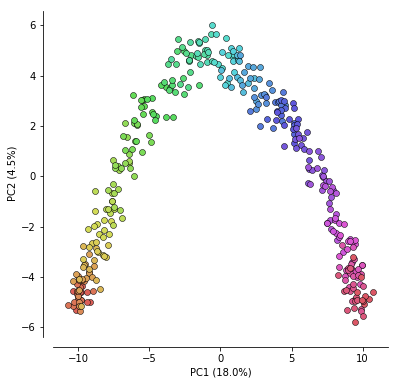

In [8]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label=str(0), color=type_color[str(0)], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages[1:]:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=str(a),
                color=type_color[str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
# ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Text(0.5,1.02,'PC maps')

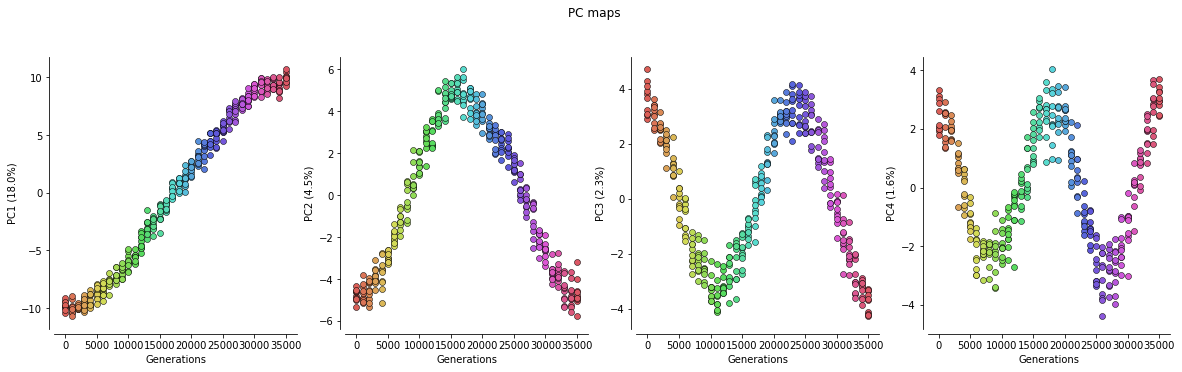

In [9]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    # modern samples
    y = coords[0:nbM, pc]
    x = np.zeros(len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label=str(0), color=type_color[str(0)], markersize=6, mec='k', mew=.5)
    i = nbM
    l = nbM
    # ancient samples
    for a in ages[1:]:
        y = coords[i:i+nbA, pc]
        x = np.ones(len(y))
        ax.plot(x*a, y, marker='o', linestyle=' ', label=a, color=type_color[str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Generations')
    
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(1,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(1,4,4)
plot_PC_maps(coords, model, 3, ax)
# ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

Covariance of raw data set:

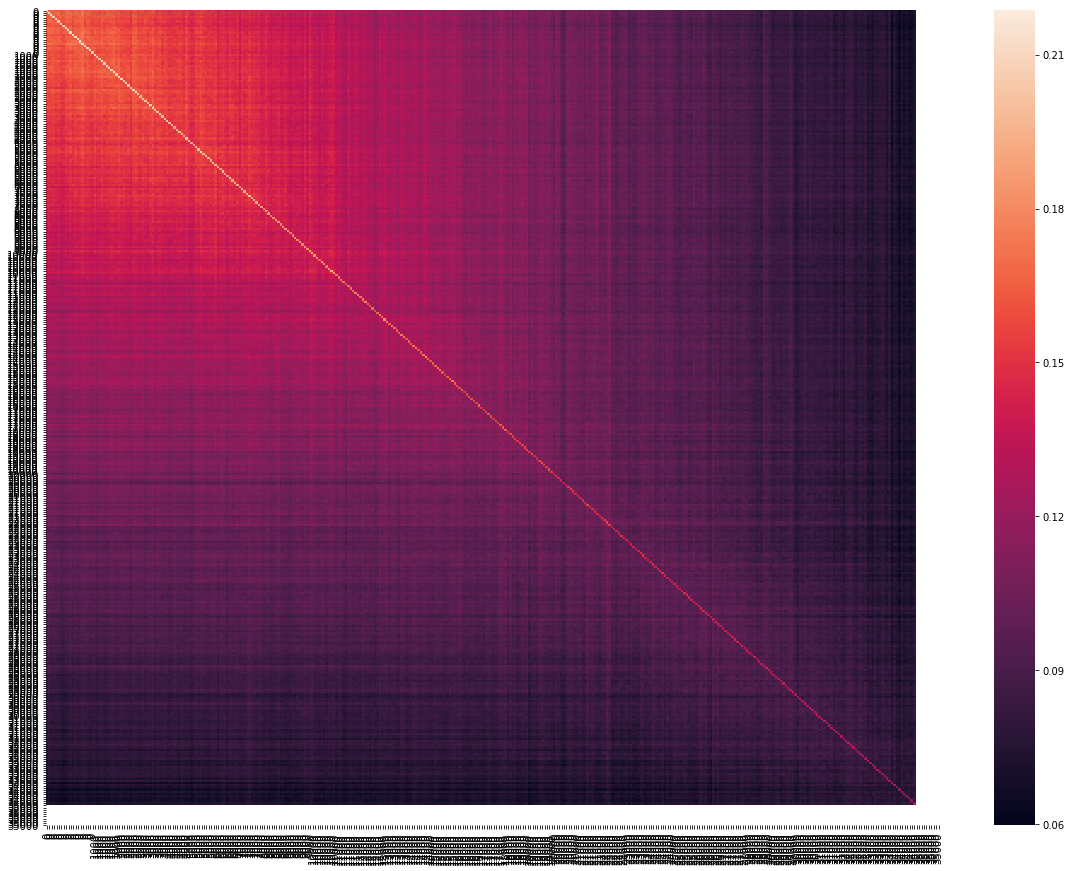

In [10]:
# Covariance matrix
times2 = [0] + ages
times = []
for i in np.arange(nbM):
    times.append(times2[0])
k = 1
for a in ages:
    for j in np.arange(nbA):
        times.append(times2[k])
    k += 1
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(np.cov(gn, rowvar=False), xticklabels=times, yticklabels=times)

In [11]:
covMat = np.cov(gn, rowvar=False)

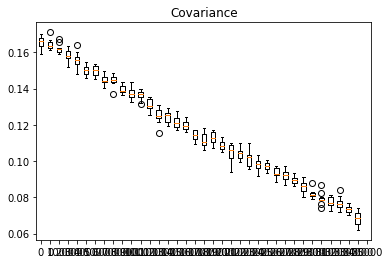

In [12]:
x = []
x1 = []
for i in np.arange(1,nbM):
    x1.append(times2[0])
k = 1
x.append(x1)
for a in ages:
    x1 = []
    for j in np.arange(nbA):
        x1.append(times2[k])
    k += 1
    x.append(x1)
    
covs = []
covs.append(covMat[0, 1:nbM])
i = nbM
for a in ages:
    covs.append(covMat[0, i:i+nbA])
    i += nbA
    
fig, ax = plt.subplots()
ax.boxplot(covs)
plt.xticks(np.arange(1, len(times2)+1), times2)
plt.title('Covariance')
plt.show()

When the data set is not mean-centered, covariance decays linearly with temporal distance between individuals.

Covariance of the mean-centered data set:

In [18]:
gn = g.to_n_alt()[:]
new_gn = []
for v in np.arange(gn.shape[0]):
    moy = np.mean(gn[v,:])
    new_gn.append(gn[v,:] - moy)
new_gn = np.asarray(new_gn)

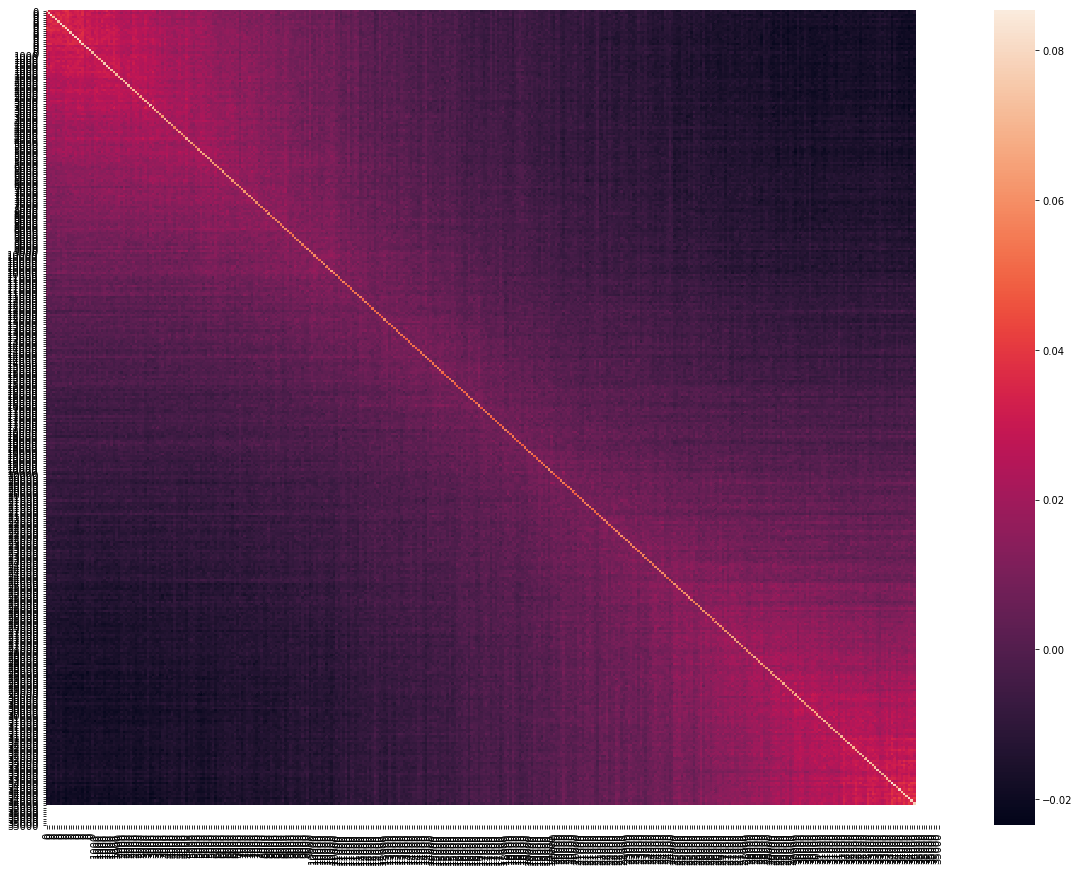

In [19]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(np.cov(new_gn, rowvar=False), xticklabels=times, yticklabels=times)

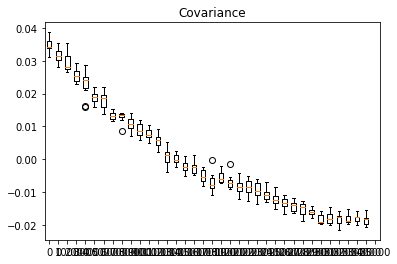

In [16]:
covMat = np.cov(new_gn, rowvar=False)

x = []
x1 = []
for i in np.arange(1,nbM):
    x1.append(times2[0])
k = 1
x.append(x1)
for a in ages:
    x1 = []
    for j in np.arange(nbA):
        x1.append(times2[k])
    k += 1
    x.append(x1)
    
covs = []
covs.append(covMat[0, 1:nbM])
i = nbM
for a in ages:
    covs.append(covMat[0, i:i+nbA])
    i += nbA
    
fig, ax = plt.subplots()
ax.boxplot(covs)
plt.xticks(np.arange(1, len(times2)+1), times2)
plt.title('Covariance')
plt.show()

When the data set is mean-centered, covariance decays with the temporal distance, but not linearly.

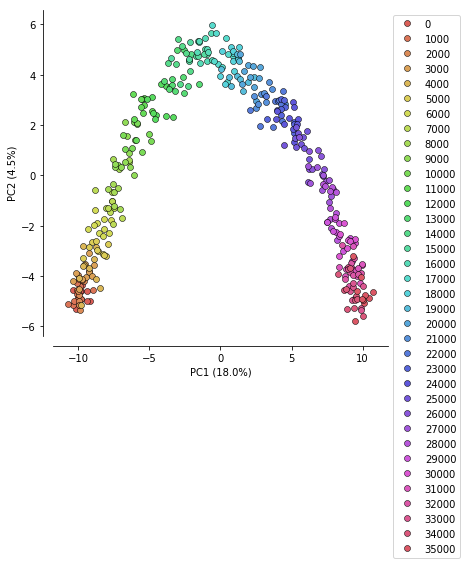

In [20]:
coords, model = allel.stats.pca(new_gn, scaler=None)
coords.shape

fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Text(0.5,1.02,'PC maps')

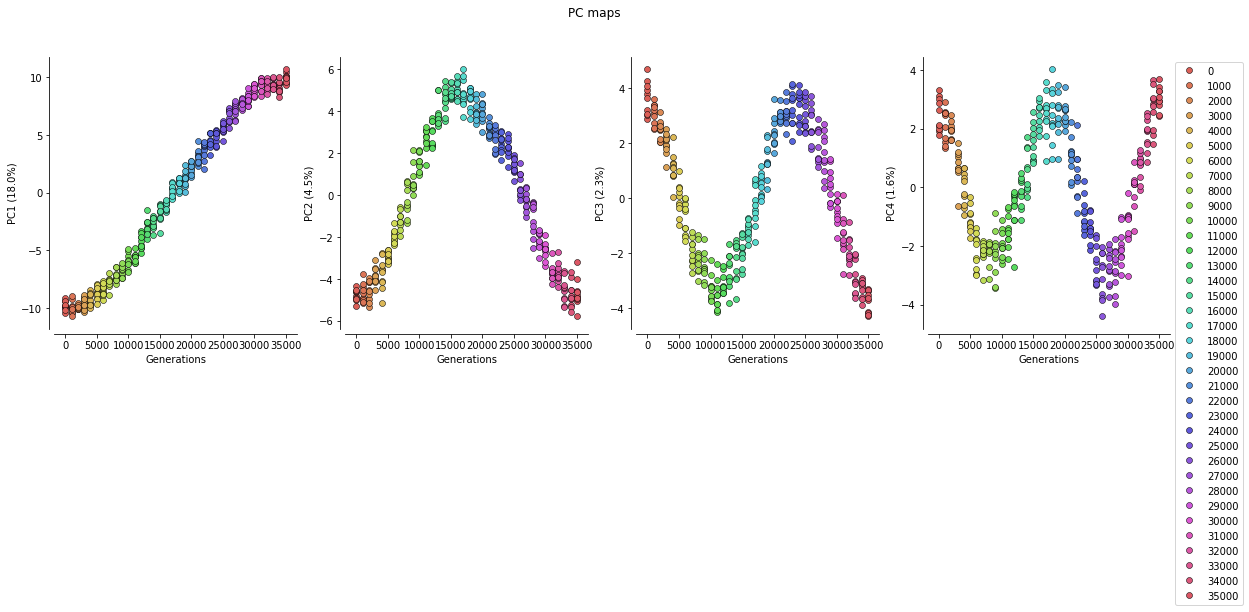

In [21]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(1,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(1,4,4)
plot_PC_maps(coords, model, 3, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

### Compare 2 temporal demes by restricting to variable markers between these 2 demes

In [27]:
nbM = 1 # number of modern samples
nbA = 1 # number of ancient samples
ages = [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000] 
samples = createSamples(nbM, nbA, ages)

In [28]:
g = allel.model.GenotypeArray(run_sim(50000, nbA, nbM))
g

<GenotypeArray shape=(6914, 10, 2) dtype=int8>
1/0 0/0 0/0 0/0 0/0 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 0/0 0/0 1/0 0/1 0/0
0/0 0/0 0/0 0/0 0/0 1/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/1 1/1 0/0 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 0/1 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 0/0 0/1 0/0 0/0 0/0

In [32]:
gn = g.to_n_alt()[:]
new_gn = {}
for i in np.arange(gn.shape[1]-1):
    new = []
    for j in np.arange(gn.shape[0]):
        if gn[j,i] != gn[j,i+1]:
            new.append([gn[j,i], gn[j, i+1]])
    new_gn[str(i)+'_'+str(i+1)] = np.array(new)

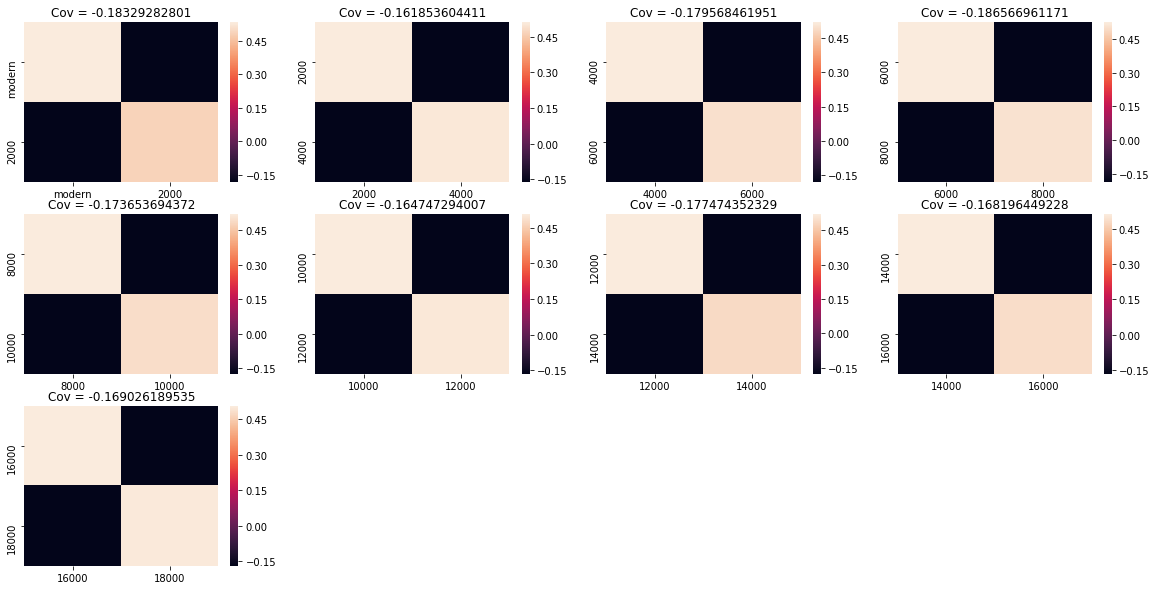

In [34]:
fig = plt.figure(figsize=(20, 10))
k = 1
for key in new_gn.keys():
    demes = key.split('_')
    time_labs = [times[int(i)] for i in demes]
    ax = fig.add_subplot(3,4,k)
    sns.heatmap(np.cov(new_gn[key], rowvar=False), xticklabels=time_labs, yticklabels=time_labs)
    plt.title('Cov = '+ str(np.cov(new_gn[key], rowvar=False)[0,1]))
    k+=1

### Not restricting to variable markers between 2 demes = all markers

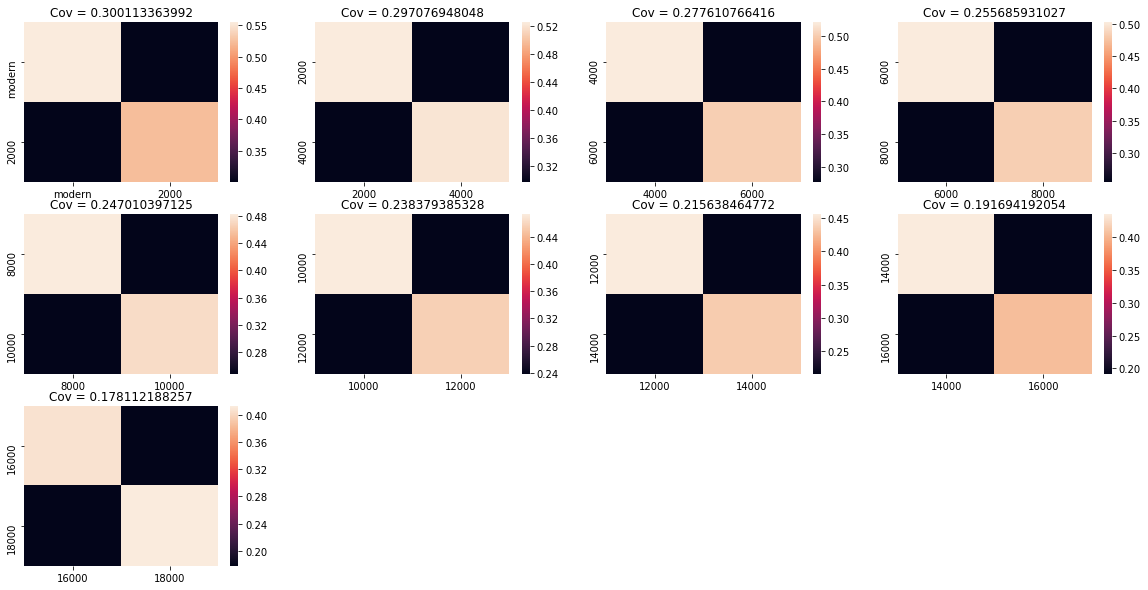

In [35]:
fig = plt.figure(figsize=(20, 10))
k = 1
for s in np.arange(gn.shape[1]-1):
    demes = [s, s+1]
    time_labs = [times[i] for i in demes]
    ax = fig.add_subplot(3,4,k)
    sns.heatmap(np.cov(gn[:,s:s+2], rowvar=False), xticklabels=time_labs, yticklabels=time_labs)
    plt.title('Cov = '+ str(np.cov(gn[:,s:s+2], rowvar=False)[0,1]))
    k += 1

Covariance estimator: $$\hat{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=0}^{n} (x_{i} - \bar{x})(y_{i} - \bar{y})$$
With n = number of SNPs, X = vector of derived allele counts for sample 1, Y = vector of derived allele counts for sample 2. <br>
Covariance is the level to which 2 variables vary together.<br>
Samples taken at t=0 and t=2,000 have varied together longer than samples taken at t=18,000 and t=20,000, so $Cov(0, 2000) > Cov(18000,20000)$.